In [1]:
#tensorboard via command-line:
#tensorboard --logdir=where your Logs directory is

In [2]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#What is the maximum flare class produced by an AR in the next 24hrs after a 24hr time sequence?
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#feature data from - hmi.sharp_720s:::
#http://jsoc.stanford.edu/doc/data/hmi/sharp/sharp.htm

#label data from - GOES flare events:::
#ftp://ftp.swpc.noaa.gov/pub/warehouse/

#and from - GOES XRS Report:::
#https://www.ngdc.noaa.gov/stp/space-weather/solar-data/solar-features/solar-flares/x-rays/goes/xrs/
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#binary class - F for flare and N for no flare
#multi-class - #6 flare classes: N is no flare, A is smallest, X is largest
               #key = {'N', 'A', 'B', 'C', 'M', 'X'}
               #['A' class flares generally not listed in official reports due to small size]
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

In [3]:
import tensorflow as tf
print("tensorflow version:", tf.__version__) #2.3.1 used
from tensorflow import keras
import os
import glob
import shutil
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
from astropy.time import Time
from matplotlib import pyplot as plt
from sklearn.metrics import f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dropout, Dense, Embedding, Flatten, SimpleRNN, LSTM, GRU, Bidirectional
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
import drms #https://pypi.org/project/drms/
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
import Flare_Data
import Feature_Years
import Make_TB_Logs
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

tensorflow version: 2.3.1


In [4]:
Feature_Years.generate_all_feature_years()

CSVs compiled.


In [5]:
where_logs = Make_TB_Logs.make_clear_tensorboard_folder()

In [6]:
#binary = True for binary classification, binary = False for multi-class classification
X_train, X_val, X_test, y_train, y_val, y_test, tim_steps, n_feats, count_of_classes, a_encoder = Flare_Data.getAllData(binary = True)

The time series starts from:  2012-01-01 00:11:26
The time series ends on:  2015-12-31 23:47:24
(array(['F', 'N'], dtype='<U1'), array([564, 536], dtype=int64))


In [7]:
print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(440, 114, 20) (440, 114, 20) (220, 114, 20) (440, 1) (440, 1) (220, 1)


In [8]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

In [120]:
batch_size = 16
epochs = 200
optimizer = RMSprop(lr=0.0001, rho=0.9, epsilon=1e-06, decay=0.0)

In [121]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~[GRU_1 Model]~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~[Binary-Class]~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~[Single Layer]~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
model = Sequential()
model.add((GRU(16,  input_shape=(tim_steps, n_feats))))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['binary_accuracy'])
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

In [122]:
tensorboard_call = keras.callbacks.TensorBoard(log_dir=where_logs, histogram_freq=1)
val_loss_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [123]:
history = model.fit(X_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(X_val, y_val), 
                    verbose=1, 
                    callbacks=[tensorboard_call, val_loss_callback])

Epoch 1/200
28/28 [==============================] - 4s 137ms/step - loss: 0.7504 - binary_accuracy: 0.5136 - val_loss: 0.7480 - val_binary_accuracy: 0.5045
Epoch 2/200
28/28 [==============================] - 1s 33ms/step - loss: 0.7270 - binary_accuracy: 0.5068 - val_loss: 0.7311 - val_binary_accuracy: 0.5091
Epoch 3/200
28/28 [==============================] - 1s 33ms/step - loss: 0.7129 - binary_accuracy: 0.5136 - val_loss: 0.7207 - val_binary_accuracy: 0.5023
Epoch 4/200
28/28 [==============================] - 1s 31ms/step - loss: 0.7036 - binary_accuracy: 0.5159 - val_loss: 0.7132 - val_binary_accuracy: 0.4955
Epoch 5/200
28/28 [==============================] - 1s 32ms/step - loss: 0.6976 - binary_accuracy: 0.5250 - val_loss: 0.7090 - val_binary_accuracy: 0.4773
Epoch 6/200
28/28 [==============================] - 1s 33ms/step - loss: 0.6949 - binary_accuracy: 0.5341 - val_loss: 0.7075 - val_binary_accuracy: 0.4523
Epoch 7/200
28/28 [==============================] - 1s 32ms/st

28/28 [==============================] - 1s 31ms/step - loss: 0.6806 - binary_accuracy: 0.5886 - val_loss: 0.7027 - val_binary_accuracy: 0.4818
Epoch 52/200
28/28 [==============================] - 1s 33ms/step - loss: 0.6803 - binary_accuracy: 0.5909 - val_loss: 0.7026 - val_binary_accuracy: 0.4864
Epoch 53/200
28/28 [==============================] - 1s 31ms/step - loss: 0.6800 - binary_accuracy: 0.5909 - val_loss: 0.7025 - val_binary_accuracy: 0.4841
Epoch 54/200
28/28 [==============================] - 1s 33ms/step - loss: 0.6798 - binary_accuracy: 0.5932 - val_loss: 0.7025 - val_binary_accuracy: 0.4864
Epoch 55/200
28/28 [==============================] - 1s 30ms/step - loss: 0.6795 - binary_accuracy: 0.5909 - val_loss: 0.7024 - val_binary_accuracy: 0.4909
Epoch 56/200
28/28 [==============================] - 1s 34ms/step - loss: 0.6791 - binary_accuracy: 0.5909 - val_loss: 0.7024 - val_binary_accuracy: 0.4864
Epoch 57/200
28/28 [==============================] - 1s 33ms/step - lo

28/28 [==============================] - 1s 29ms/step - loss: 0.6639 - binary_accuracy: 0.6273 - val_loss: 0.6990 - val_binary_accuracy: 0.5136
Epoch 104/200
28/28 [==============================] - 1s 30ms/step - loss: 0.6633 - binary_accuracy: 0.6364 - val_loss: 0.6990 - val_binary_accuracy: 0.5136
Epoch 105/200
28/28 [==============================] - 1s 31ms/step - loss: 0.6630 - binary_accuracy: 0.6341 - val_loss: 0.6990 - val_binary_accuracy: 0.5136
Epoch 106/200
28/28 [==============================] - 1s 30ms/step - loss: 0.6627 - binary_accuracy: 0.6318 - val_loss: 0.6989 - val_binary_accuracy: 0.5159
Epoch 107/200
28/28 [==============================] - 1s 30ms/step - loss: 0.6622 - binary_accuracy: 0.6364 - val_loss: 0.6988 - val_binary_accuracy: 0.5182
Epoch 108/200
28/28 [==============================] - 1s 31ms/step - loss: 0.6618 - binary_accuracy: 0.6295 - val_loss: 0.6987 - val_binary_accuracy: 0.5205
Epoch 109/200
28/28 [==============================] - 1s 30ms/ste

In [124]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_7 (GRU)                  (None, 16)                1824      
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 17        
Total params: 1,841
Trainable params: 1,841
Non-trainable params: 0
_________________________________________________________________


In [125]:
#evaluate model on test set
results = model.evaluate(X_test, y_test, batch_size=1, verbose=1)
print("test loss, test acc:", results)

220/220 [==============================] - 1s 4ms/step - loss: 0.6768 - binary_accuracy: 0.5955
test loss, test acc: [0.6767633557319641, 0.5954545736312866]


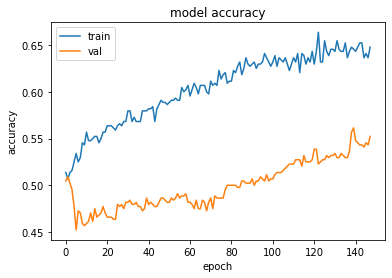

In [126]:
#summarize history for accuracy
plt.plot(history.history[(list(history.history.keys())[1])])
plt.plot(history.history[(list(history.history.keys())[3])])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

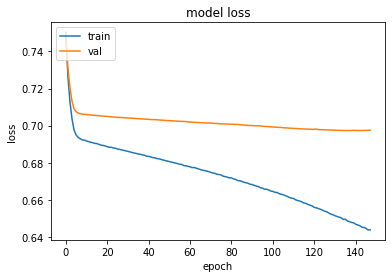

In [127]:
#summarize history for loss
plt.plot(history.history[(list(history.history.keys())[0])])
plt.plot(history.history[(list(history.history.keys())[2])])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [128]:
#generate predictions
predictions = model.predict(X_test)
print("predictions:", predictions)

predictions: [[0.39936352]
 [0.4656846 ]
 [0.4913335 ]
 [0.39473352]
 [0.5455726 ]
 [0.49555212]
 [0.6222352 ]
 [0.5119144 ]
 [0.7442763 ]
 [0.38087872]
 [0.44014314]
 [0.44752207]
 [0.4815493 ]
 [0.45630658]
 [0.3667209 ]
 [0.43287686]
 [0.45022815]
 [0.47596738]
 [0.33355916]
 [0.3506205 ]
 [0.48042077]
 [0.3380692 ]
 [0.4270761 ]
 [0.4540326 ]
 [0.40600747]
 [0.44549057]
 [0.46420264]
 [0.46675152]
 [0.5018329 ]
 [0.48896542]
 [0.39572293]
 [0.6807289 ]
 [0.6267471 ]
 [0.58420134]
 [0.52743375]
 [0.51344836]
 [0.57635736]
 [0.42760372]
 [0.44309   ]
 [0.54812825]
 [0.32978892]
 [0.65993714]
 [0.53832537]
 [0.38144356]
 [0.46043813]
 [0.32577574]
 [0.41969806]
 [0.22664395]
 [0.42786348]
 [0.3853515 ]
 [0.34193817]
 [0.58805525]
 [0.46995178]
 [0.3575701 ]
 [0.42663255]
 [0.5136702 ]
 [0.5522825 ]
 [0.49705848]
 [0.60958076]
 [0.6637234 ]
 [0.40045217]
 [0.35916954]
 [0.64869505]
 [0.64158773]
 [0.6405772 ]
 [0.3527885 ]
 [0.35221535]
 [0.3759547 ]
 [0.26054817]
 [0.45046228]
 [0.539

In [129]:
#remove encoding
real_predictions_B = a_encoder.inverse_transform(predictions)
print(real_predictions_B)

['F' 'F' 'F' 'F' 'N' 'F' 'N' 'N' 'N' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F'
 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'N' 'F' 'F' 'N' 'N' 'N' 'N' 'N'
 'N' 'F' 'F' 'N' 'F' 'N' 'N' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'N' 'F' 'F'
 'F' 'N' 'N' 'F' 'N' 'N' 'F' 'F' 'N' 'N' 'N' 'F' 'F' 'F' 'F' 'F' 'N' 'F'
 'N' 'F' 'F' 'F' 'F' 'N' 'F' 'F' 'F' 'F' 'N' 'F' 'F' 'N' 'F' 'N' 'N' 'N'
 'F' 'N' 'F' 'F' 'F' 'N' 'N' 'F' 'F' 'F' 'N' 'F' 'F' 'F' 'N' 'F' 'N' 'N'
 'F' 'N' 'N' 'N' 'N' 'F' 'N' 'F' 'N' 'F' 'N' 'F' 'F' 'F' 'F' 'F' 'F' 'F'
 'F' 'N' 'N' 'N' 'N' 'F' 'F' 'F' 'F' 'F' 'N' 'F' 'F' 'F' 'N' 'F' 'N' 'F'
 'F' 'N' 'F' 'F' 'F' 'F' 'N' 'F' 'N' 'F' 'F' 'N' 'F' 'N' 'N' 'N' 'F' 'F'
 'N' 'F' 'F' 'F' 'N' 'N' 'F' 'F' 'N' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'F'
 'N' 'F' 'F' 'F' 'F' 'F' 'N' 'N' 'F' 'N' 'F' 'F' 'F' 'N' 'F' 'N' 'N' 'N'
 'N' 'F' 'F' 'F' 'F' 'N' 'N' 'N' 'N' 'N' 'N' 'F' 'F' 'F' 'F' 'N' 'N' 'N'
 'N' 'F' 'N' 'F']


In [130]:
#prediction counts
unique, counts = np.unique(real_predictions_B, return_counts=True)
dict(zip(unique, counts))

{'F': 138, 'N': 82}

In [131]:
#y_test predictions
ytest_predictions = a_encoder.inverse_transform(y_test)
print(ytest_predictions)

['F' 'F' 'N' 'N' 'F' 'N' 'N' 'N' 'F' 'N' 'F' 'F' 'F' 'N' 'F' 'N' 'F' 'N'
 'N' 'F' 'N' 'F' 'F' 'F' 'N' 'N' 'N' 'F' 'F' 'N' 'F' 'N' 'N' 'F' 'N' 'N'
 'N' 'F' 'N' 'N' 'F' 'F' 'F' 'N' 'F' 'N' 'N' 'F' 'N' 'F' 'F' 'N' 'N' 'F'
 'N' 'N' 'F' 'N' 'N' 'F' 'F' 'N' 'F' 'N' 'F' 'F' 'N' 'F' 'F' 'N' 'F' 'F'
 'N' 'N' 'F' 'F' 'N' 'N' 'N' 'F' 'N' 'F' 'N' 'F' 'F' 'N' 'F' 'N' 'N' 'N'
 'N' 'N' 'N' 'F' 'F' 'N' 'N' 'F' 'F' 'N' 'F' 'F' 'N' 'N' 'N' 'F' 'F' 'N'
 'F' 'N' 'N' 'F' 'N' 'F' 'F' 'F' 'F' 'F' 'F' 'F' 'N' 'F' 'F' 'F' 'F' 'F'
 'F' 'N' 'N' 'F' 'N' 'N' 'N' 'N' 'F' 'F' 'N' 'N' 'F' 'F' 'N' 'F' 'N' 'N'
 'F' 'F' 'F' 'F' 'F' 'N' 'N' 'N' 'N' 'N' 'N' 'N' 'F' 'F' 'F' 'N' 'F' 'N'
 'N' 'N' 'F' 'F' 'N' 'N' 'F' 'F' 'F' 'F' 'N' 'N' 'N' 'F' 'N' 'N' 'F' 'N'
 'N' 'N' 'F' 'F' 'F' 'F' 'F' 'N' 'F' 'F' 'N' 'N' 'F' 'F' 'N' 'N' 'N' 'N'
 'N' 'F' 'F' 'N' 'F' 'F' 'F' 'N' 'N' 'F' 'N' 'F' 'F' 'F' 'F' 'F' 'F' 'F'
 'F' 'N' 'N' 'F']


In [132]:
#real count
unique, counts = np.unique(ytest_predictions, return_counts=True)
dict(zip(unique, counts))

{'F': 113, 'N': 107}

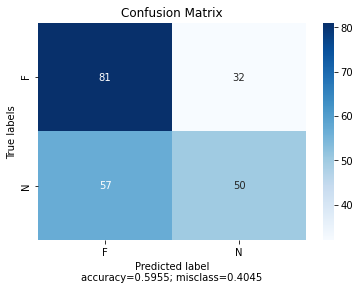

In [133]:
#confusion matrix
matrix = confusion_matrix(ytest_predictions, real_predictions_B)
#format confusion matrix
ax=plt.subplot()
sns.heatmap(matrix, annot=True, ax = ax, cmap='Blues', fmt='g');
accuracy = np.trace(matrix) / np.sum(matrix).astype('float')
misclass = 1 - accuracy
ax.set_xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass));
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix');
ax.xaxis.set_ticklabels(unique); ax.yaxis.set_ticklabels(unique);

In [134]:
print(classification_report(ytest_predictions, real_predictions_B))

              precision    recall  f1-score   support

           F       0.59      0.72      0.65       113
           N       0.61      0.47      0.53       107

    accuracy                           0.60       220
   macro avg       0.60      0.59      0.59       220
weighted avg       0.60      0.60      0.59       220



In [135]:
#macro - calculate metrics for each label, and find their unweighted mean
pre_score = precision_score(ytest_predictions, real_predictions_B, average = "macro")
print('precision score:{:0.4f}'.format(pre_score))
recall_score_1 = recall_score(ytest_predictions, real_predictions_B, average= "macro")
print('recall score:{:0.4f}'.format(recall_score_1))
f1_score_1 = f1_score(ytest_predictions, real_predictions_B, average="macro")
print('f1 score:{:0.4f}'.format(f1_score_1))

precision score:0.5984
recall score:0.5921
f1 score:0.5873
